In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import joblib

In [36]:
url = 'https://raw.githubusercontent.com/Projetos-III-UFPA-2024-4/engenheiros-do-acaii/main/Modelos%20-%20Previs%C3%A3o/Dados/Dataset_Final_do_Inversor_Solar.csv'
data = pd.read_csv(url, sep=',')
print(data.head())

             timestamp  hora  minuto  DP1  energia_gerada_kWh
0  2025-03-01 00:00:00     0       0  0.0                 0.0
1  2025-03-01 00:15:00     0      15  0.0                 0.0
2  2025-03-01 00:30:00     0      30  0.0                 0.0
3  2025-03-01 00:45:00     0      45  0.0                 0.0
4  2025-03-01 01:00:00     1       0  0.0                 0.0


In [37]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [38]:
# Preparando dados para Prophet
df = data.reset_index()[["timestamp", "energia_gerada_kWh"]]
df.columns = ["ds", "y"]

In [39]:
df.tail()

,ds,y
2875,2025-03-30 22:45:00,0.0
2876,2025-03-30 23:00:00,0.0
2877,2025-03-30 23:15:00,0.0
2878,2025-03-30 23:30:00,0.0
2879,2025-03-30 23:45:00,0.0


In [40]:
# 🔹 Criar o modelo Prophet e treinar
modelo = Prophet()
modelo.fit(df)

22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:20 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# 🔹 Fazer previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods=2880, freq="15T")
previsao = modelo.predict(futuro)

C:\Users\thzli\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


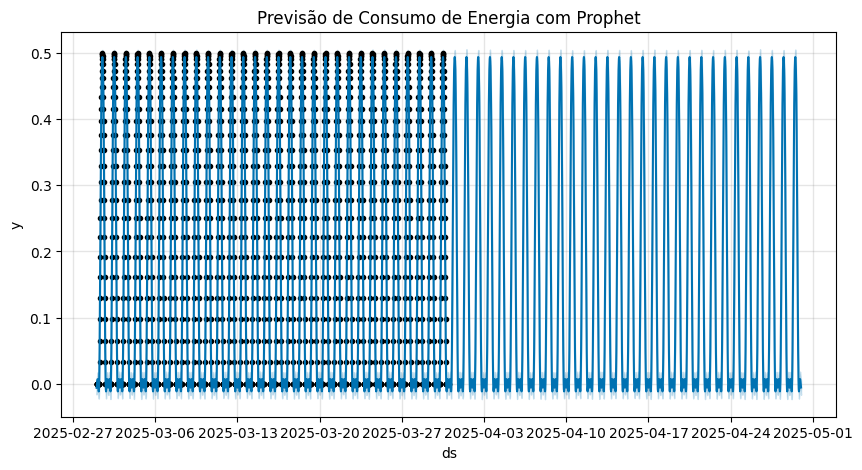

In [42]:
# 🔹 Plotar a previsão
fig, ax = plt.subplots(figsize=(10, 5))
modelo.plot(previsao, ax=ax)
plt.title("Previsão de Consumo de Energia com Prophet")
plt.show()

In [44]:
joblib.dump(modelo, "modelo_prophet.pkl")

['modelo_prophet.pkl']

### Salvar no Banco

In [76]:
previsao_data = previsao[['ds', 'yhat']]

In [78]:
previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)

C:\Users\thzli\AppData\Local\Temp\ipykernel_9220\2965436896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)


In [79]:
previsao_data

,timestamp,geracao (kwh)
0,2025-03-01 00:00:00,-0.006180
1,2025-03-01 00:15:00,-0.005824
2,2025-03-01 00:30:00,-0.004797
3,2025-03-01 00:45:00,-0.003206
4,2025-03-01 01:00:00,-0.001216
...,...,...
5755,2025-04-29 22:45:00,0.001055
5756,2025-04-29 23:00:00,-0.001120
5757,2025-04-29 23:15:00,-0.003108
5758,2025-04-29 23:30:00,-0.004697


In [89]:
from sqlalchemy import create_engine
import pymysql

In [90]:
DB_USERNAME = "engdoacaii"
DB_PASSWORD = "p3smartvolt"
DB_NAME = "smartvolt"
DB_HOST = "smartvoltinstancia.cwt38ijjojpt.us-east-1.rds.amazonaws.com"
DB_DIALECT = "mysql"
TABLE_NAME = "previsao_producao"

In [91]:
# 🔹 Criar conexão com o MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME,
)
cursor = conn.cursor()

In [92]:
query = f"""
INSERT INTO {TABLE_NAME} (`geracao (kwh)`, `timestamp`)
VALUES (%s, %s)
"""

In [95]:
# 🔹 Inserir previsões no banco usando apenas `ds` e `yhat`, renomeados na query
for _, row in previsao_data.iterrows():
    cursor.execute(query, (row["geracao (kwh)"], row["timestamp"]))

# 🔹 Confirmar e fechar conexão
conn.commit()
cursor.close()
conn.close()

In [96]:
# 🔹 Criar conexão com MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME
)
cursor = conn.cursor()

# 🔹 Query SQL para buscar as últimas 10 linhas inseridas
query = f"""
SELECT * FROM {TABLE_NAME}
ORDER BY timestamp DESC
LIMIT 10;
"""

# 🔹 Executar a consulta
cursor.execute(query)

# 🔹 Obter os resultados e armazenar em um DataFrame Pandas
colunas = [desc[0] for desc in cursor.description]  # Captura os nomes das colunas
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=colunas)  # Criar DataFrame com os resultados

# 🔹 Fechar conexão
cursor.close()
conn.close()

# 🔹 Mostrar os dados no terminal
print("\n🔹 Últimas 10 Previsões Inseridas no Banco:")
print(df)


🔹 Últimas 10 Previsões Inseridas no Banco:
     id  geracao (kwh)           timestamp
0  5760      -0.005721 2025-04-29 23:45:00
1  5759      -0.004697 2025-04-29 23:30:00
2  5758      -0.003108 2025-04-29 23:15:00
3  5757      -0.001120 2025-04-29 23:00:00
4  5756       0.001055 2025-04-29 22:45:00
5  5755       0.003178 2025-04-29 22:30:00
6  5754       0.005006 2025-04-29 22:15:00
7  5753       0.006311 2025-04-29 22:00:00
8  5752       0.006907 2025-04-29 21:45:00
9  5751       0.006670 2025-04-29 21:30:00
